이번 주차 과제는 간단한 이미지 데이터를 활용해 크기가 큰 데이터의 차원 축소를 진행하고 데이터의 라벨에 따라 클러스터링을 진행하는 과제입니다.

###필요한 모듈을 가져오세요.

In [73]:
#pip install kaggle

# Image data 가져오기
https://www.kaggle.com/datasets/zalando-research/fashionmnist/data

###위 링크의 fashion mnist 데이터의 train dataset과 test dataset을 가져오세요.
(데이터의 용량이 크니 직접 다운로드 하지 말고 코드를 이용해 가져오도록 해보세요.)

In [74]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import numpy as np
import pandas as pd
# Kaggle API 
api = KaggleApi()
api.authenticate()

# 데이터셋 다운로드 
dataset = "zalando-research/fashionmnist"
api.dataset_download_files(dataset, path="./fashion_mnist", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist


In [75]:
import pandas as pd

# 데이터 불러오기
train_data = pd.read_csv("./fashion_mnist/fashion-mnist_train.csv")
test_data = pd.read_csv("./fashion_mnist/fashion-mnist_test.csv")

# 이미지와 레이블 데이터 분리
x_train = train_data.drop(columns=["label"]).values.reshape(-1, 1, 28, 28)  # (num_samples, channels, height, width)
y_train = train_data["label"].values
x_test = test_data.drop(columns=["label"]).values.reshape(-1, 1, 28, 28)
y_test = test_data["label"].values


# 데이터 형태 확인
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (60000, 1, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 1, 28, 28)
y_test shape: (10000,)


###데이터에 대한 정보들을 보여주세요.
(필수: 요약, 모양, 크기, 결측치 여부 등)

In [76]:
# 데이터 요약 정보 출력
print("=== Train Data 정보 ===")
print(train_data.info())  #
print("\n데이터 요약 통계:\n", train_data.describe()) 
print("\n데이터 모양 (행, 열):", train_data.shape)  

# 결측치 여부 확인
print("\n결측치 여부:\n", train_data.isnull().sum())

print("\n\n=== Test Data 정보 ===")
print(test_data.info())  
print("\n데이터 요약 통계:\n", test_data.describe())  
print("\n데이터 모양 (행, 열):", test_data.shape)  

# 결측치 여부 확인
print("\n결측치 여부:\n", test_data.isnull().sum())

=== Train Data 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None

데이터 요약 통계:
               label        pixel1        pixel2        pixel3        pixel4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000000    226.000000    164.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  6000

### Data중 첫 번째 이미지를 보여주세요.

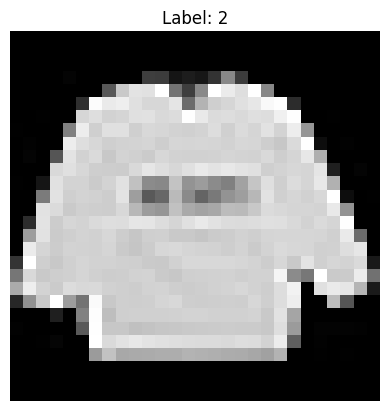

In [77]:
import matplotlib.pyplot as plt

# 첫 번째 이미지 데이터 가져오기
first_image = x_train[0].reshape(28, 28)  # 28x28로 변환
first_label = y_train[0]  # 첫 번째 이미지의 레이블

# 이미지 시각화
plt.imshow(first_image, cmap="gray")
plt.title(f"Label: {first_label}")
plt.axis("off")  # 축 제거
plt.show()

# 이미지 전처리

### 이미지 데이터를 머신러닝에 이용하기 편한 형태로 바꾸어 합니다.
(torch model 사용 - tensor 형태로 바꾸기 등)

In [78]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# numpy 배열을 tensor로 변환
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

### 이미지 데이터는 픽셀 값이 0 - 255로 이루어져 있습니다. 이 값을 0 - 1까지의 값으로 normalize 해주세요.

In [79]:
x_train_tensor_normalize = x_train_tensor/255.0
x_test_tensor_normalize = x_test_tensor/255.0

### 추가적인 이미지 전처리를 진행해주세요.
(차원을 수정하는 것은 뒤의 문제에서 진행할 것이므로 여기에서 하지 마세요.)

# 차원 축소
차원 축소란 고차원 데이터를 효율적으로 처리하기 위한 기법입니다.
### 그 중 대표적인 PCA와 t-sne에 대한 내용을 비교하여 아래에 적어주세요.

PCA:고차원 데이터를 몇 개의 주성분(principal components)으로 변환하여 저차원 공간에 투영하는 선형 차원 축소 기법\
t-sne : 데이터의 고차원 구조를 비선형적으로 저차원 공간에 시각화할 수 있는 기법으로, 특히 시각화를 목적으로 2차원 또는 3차원으로 데이터를 축소할 때 많이 사용

## PCA

### 현재 데이터는 28*28로 784차원을 가지고 있습니다. PCA를 이용하여 데이터들을 가장 잘 설명하는 50개의 변수만으로 데이터를 변환하시오.

In [80]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)

X_train_PCA = pca.fit_transform(x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1))


### PCA 이후 데이터들의 설명된 분산 비율 (explained variance ratio)를 출력하세요.

In [81]:
# 각 주성분의 설명된 분산 비율 출력
explained_variance = pca.explained_variance_ratio_
print("설명가능한 분산:")
print(explained_variance)

# 전체 설명된 분산 비율의 합계 출력
print("합계:")
print(explained_variance.sum())

설명가능한 분산:
[0.29011353 0.17727668 0.06022699 0.04970272 0.03839289 0.03470997
 0.02344044 0.01913937 0.01343605 0.01310725 0.0098979  0.0091405
 0.00765206 0.00660427 0.00609188 0.00591506 0.00552046 0.0053049
 0.00459959 0.00455534 0.00432823 0.00406103 0.00383469 0.00374221
 0.00361877 0.0035091  0.00333586 0.00318696 0.00309619 0.00295278
 0.00276007 0.00265339 0.00262961 0.00257677 0.00247554 0.00238411
 0.00230072 0.00224338 0.00219093 0.00209698 0.00200757 0.00197524
 0.00194155 0.00183744 0.0017558  0.00171141 0.00167788 0.00163637
 0.00161685 0.00155773]
합계:
0.8625229999519773


### PCA를 시행하면 데이터가 수정되므로 원본 데이터와 차이가 생기게 됩니다. 이때 이 차이를 재구성 오차(Reconstruction Error)라고 합니다. 재구성 오차를 mse(오차제곱합) 방식으로 구하시오.

In [82]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# PCA 인스턴스 생성
pca = PCA(n_components=50)

# 원본 데이터를 2D로 변환 후 PCA 적용
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
X_train_PCA = pca.fit_transform(X_train_reshaped)

# PCA로 변환된 데이터를 사용하여 원본 데이터 재구성
X_train_reconstructed = pca.inverse_transform(X_train_PCA)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = mean_squared_error(X_train_reshaped, X_train_reconstructed)

print(f"Reconstruction Error (MSE): {reconstruction_error}")


Reconstruction Error (MSE): 0.011944359926474262


### 이번에는 PCA를 통해 원본 데이터를 30차원으로 줄이고, explained variance ratio와 reconstructon error를 구하시오.

In [83]:
# PCA 인스턴스 생성
pca = PCA(n_components=30)

# 원본 데이터를 2D로 변환 후 PCA 적용
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
X_train_PCA = pca.fit_transform(X_train_reshaped)

# PCA로 변환된 데이터를 사용하여 원본 데이터 재구성
X_train_reconstructed = pca.inverse_transform(X_train_PCA)

# 재구성 오차 계산 (MSE 방식)
reconstruction_error = mean_squared_error(X_train_reshaped, X_train_reconstructed)

print(f"Reconstruction Error (MSE): {reconstruction_error}")

Reconstruction Error (MSE): 0.015592878353830133


### 데이터를 30차원으로 줄인 결과와 50차원으로 줄인 결과에는 어떤 차이가 있습니까?

높은 차원으로 압축시켰을때가 복원이 더 잘되니 오차가 적다

### 마지막으로 원본 데이터를 2차원으로 줄이고, explained variance ratio와 reconstruction error를 구하시오.

In [84]:
# PCA 인스턴스 생성
pca = PCA(n_components=2)

# 원본 데이터를 2D로 변환 후 PCA 적용
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
X_train_PCA = pca.fit_transform(X_train_reshaped)



### 2차원으로 축소한 데이터를 시각화하여 보여주세요. 대신 데이터의 label에 따라 색상을 다르게 해주세요.

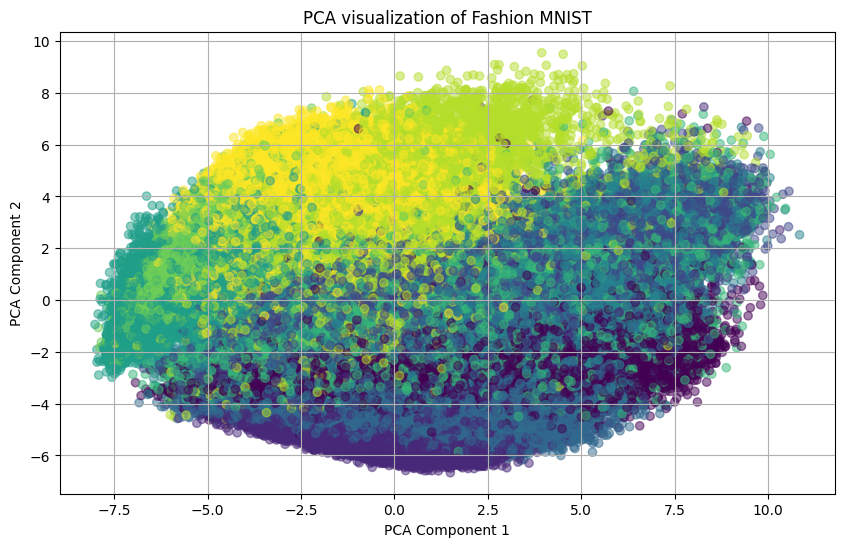

In [85]:

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1],c= y_train_tensor ,alpha=0.5)
plt.title('PCA visualization of Fashion MNIST')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

## T-SNE

### 앞서 pca를 통해 50차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

In [86]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# PCA 인스턴스 생성 및 50차원으로 축소
pca = PCA(n_components=50)
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
X_train_PCA = pca.fit_transform(X_train_reshaped)

# t-SNE 인스턴스 생성 및 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_PCA)


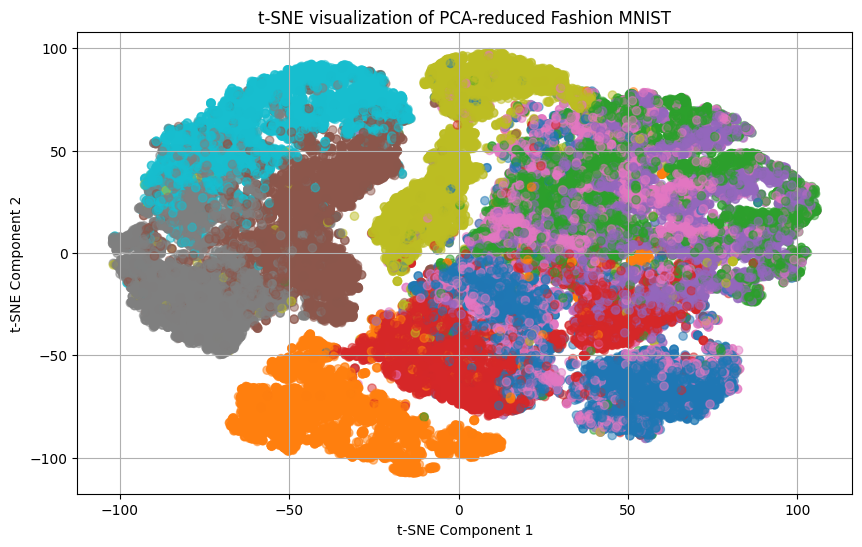

In [87]:
# 결과 시각화
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train_tensor, cmap='tab10', alpha=0.5)
plt.title('t-SNE visualization of PCA-reduced Fashion MNIST')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()

plt.show()

### 앞서 pca를 통해 30차원으로 줄인 데이터를 t-sne를 통해 시각화 하세요.

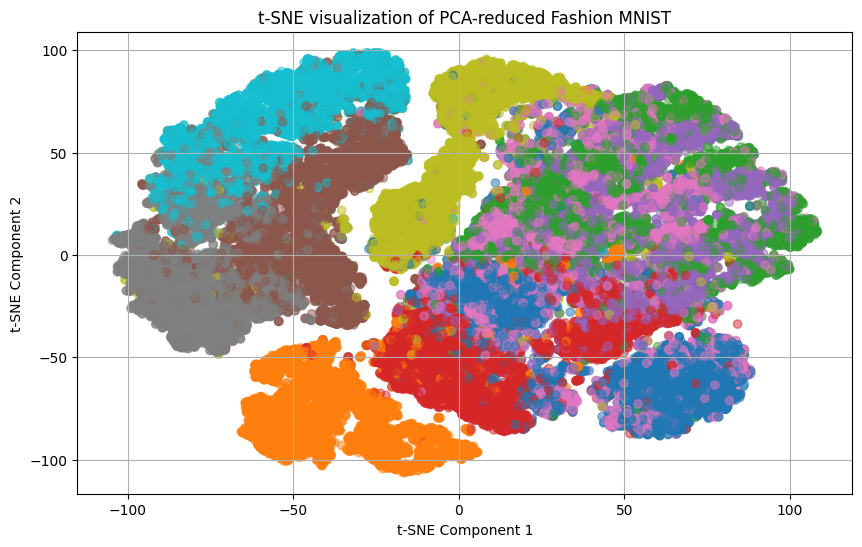

In [88]:
pca = PCA(n_components=30)
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
X_train_PCA = pca.fit_transform(X_train_reshaped)

# t-SNE 인스턴스 생성 및 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_PCA)


# 결과 시각화
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='tab10', alpha=0.5)
plt.title('t-SNE visualization of PCA-reduced Fashion MNIST')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid()

plt.show()

## 군집화

### PCA를 통해 50차원으로 줄인 데이터를 DBSCAN을 이용하여 군집화 하시오.

In [89]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

pca = PCA(n_components=50)
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
X_train_PCA = pca.fit_transform(X_train_reshaped)
param_grid = {'eps': [0.5, 1, 1.5, 2], 'min_samples': [3, 5, 10]}
best_score = -1
best_params = None

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    clusters = dbscan.fit_predict(X_train_PCA)
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    if n_clusters > 1:  # 군집이 적어도 2개 이상 형성된 경우
        silhouette_avg = silhouette_score(X_train_PCA, clusters)
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = params

print(f'Best Params: {best_params}, Best Silhouette Score: {best_score}')


Best Params: {'eps': 1, 'min_samples': 10}, Best Silhouette Score: -0.12425266277672499


### k-means를 통해 50차원으로 줄인 데이터를 군집화 하시오.(군집의 개수는 10개로 하시오.)

In [90]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# PCA 인스턴스 생성 및 50차원으로 축소
pca = PCA(n_components=50)
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
X_train_PCA = pca.fit_transform(X_train_reshaped)

# K-means 인스턴스 생성 및 군집화 (K=10)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_train_PCA)

### 엘보우 메소드를 이용하여 k-means에서 가장 적절한 군집의 개수를 구하시오.

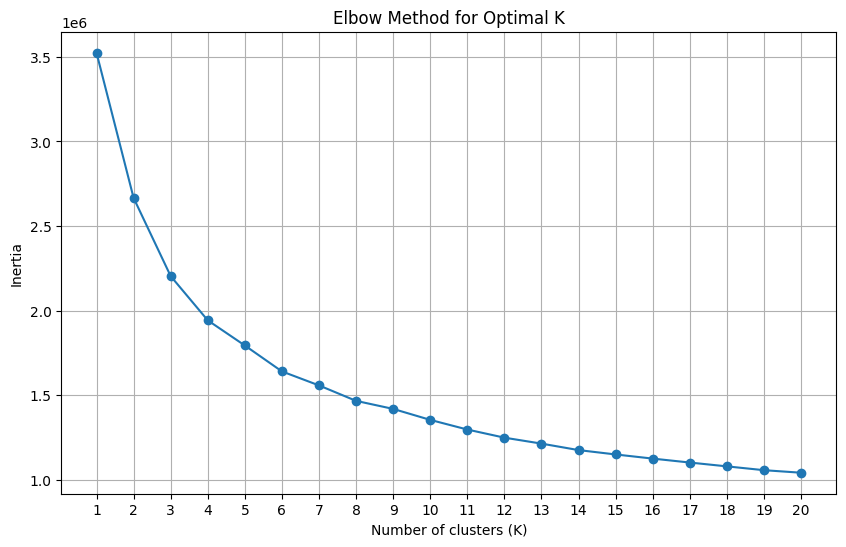

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA 인스턴스 생성 및 50차원으로 축소
pca = PCA(n_components=50)
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
X_train_PCA = pca.fit_transform(X_train_reshaped)

# 엘보우 메소드를 위한 K-means 수행
inertia = []
k_range = range(1, 21)  # K값 범위 설정

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_PCA)
    inertia.append(kmeans.inertia_)  # 군집의 왜곡을 저장

# 엘보우 플롯 시각화
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid()

plt.show()


### k-means 최적의 군집 개수로 다시 군집화 하여 시각화 하시오.

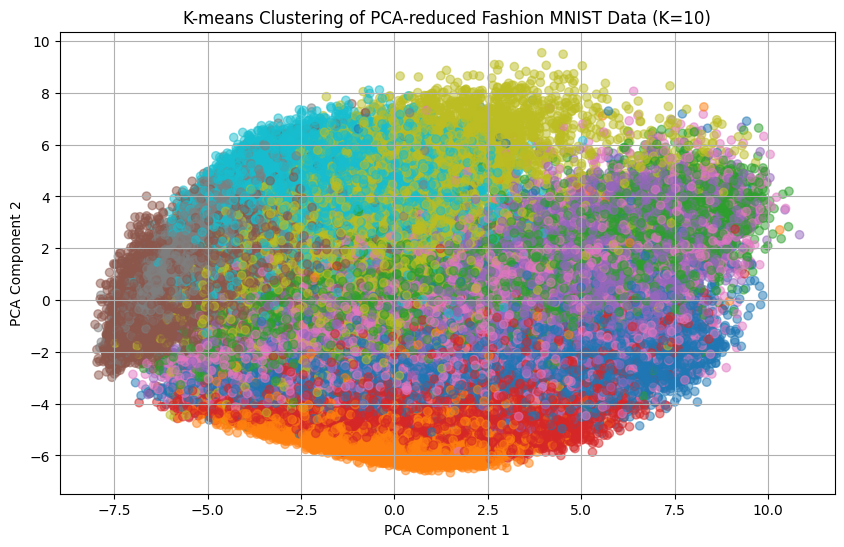

In [92]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# PCA 인스턴스 생성 및 50차원으로 축소
pca = PCA(n_components=50)
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
X_train_PCA = pca.fit_transform(X_train_reshaped)

# K-means 인스턴스 생성 및 군집화 (K=10)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_PCA)

# 군집화 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], c=y_train_tensor, cmap='tab10', alpha=0.5)
plt.title('K-means Clustering of PCA-reduced Fashion MNIST Data (K=10)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()

# 군집의 중심 출력
centers = kmeans.cluster_centers_

plt.show()


### 다른 추가적인 군집화 기법을 2가지 이상 사용하여 pca 50 데이터를 시각화 하시오.

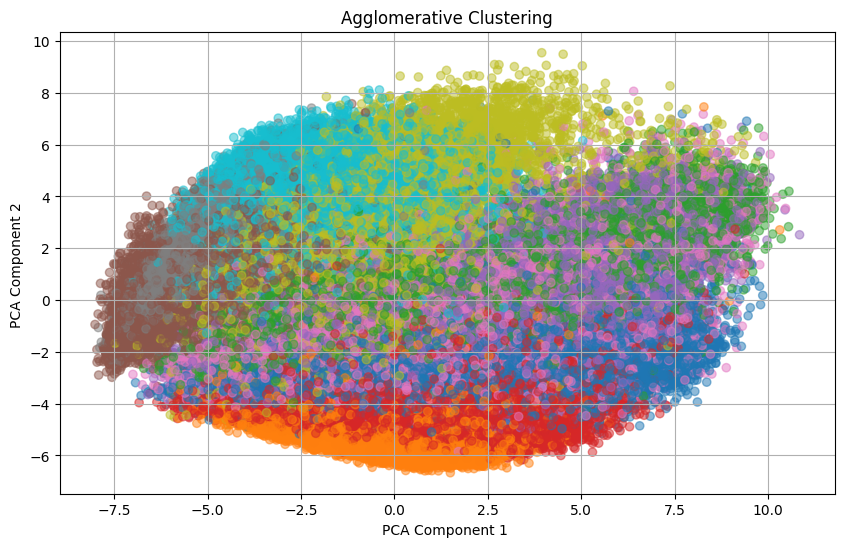

In [93]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.neighbors import kneighbors_graph

# K-Nearest Neighbors 그래프 생성
connectivity = kneighbors_graph(X_train_PCA, n_neighbors=10, include_self=False)

# Agglomerative Clustering 실행
agglo = AgglomerativeClustering(n_clusters=3, connectivity=connectivity)
clusters_agglo = agglo.fit_predict(X_train_PCA)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], c=y_train_tensor, cmap='tab10', alpha=0.5)
plt.title('Agglomerative Clustering')
plt.xlabel('PCA Component 1 ')
plt.ylabel('PCA Component 2 ')
plt.grid()
plt.show()


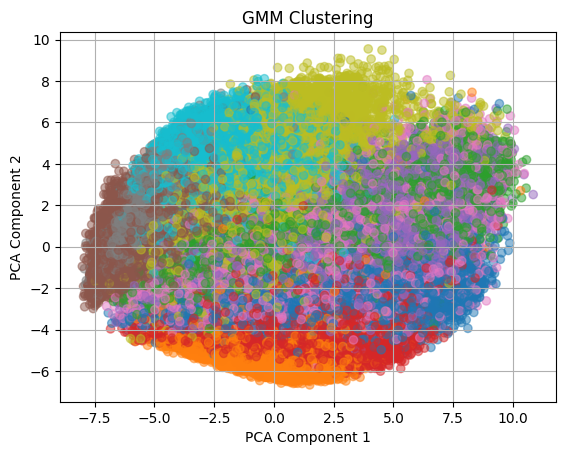

In [94]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_train_PCA)
clusters = gmm.predict(X_train_PCA)

# 시각화
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1], c=y_train_tensor, cmap='tab10', alpha=0.5)
plt.title('GMM Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.show()

## 군집화 결과 비교

### 앞선 모든 군집화 모델의 결과를 실루엣 점수(Silhouette score)를 이용하여 성능을 비교하시오.

K-Means Silhouette Scores: [0.22337896640462504, 0.22020613949548865, 0.21696138289786218, 0.19392831729436488, 0.17578284956929202, 0.18976181437141107, 0.1833573369453614, 0.20133859714043997, 0.188721965771854]
Optimal K-Means Cluster: 2
GMM BIC: [5443447.068127928, 3782360.828651572, 2595246.866728327, 1816214.1401808972, 1435683.5324935713, 1168279.1312442073, 807344.6721484355, 599901.8420286408, 477805.28835674527, 422339.0290193517]
Optimal GMM Cluster: 10, Silhouette Score: 0.09746961560994558
Agglomerative Clustering Silhouette Score: 0.1707409734788967
Best DBSCAN Parameters: eps=0.1, min_samples=3, Silhouette Score: 0.03189062207347359


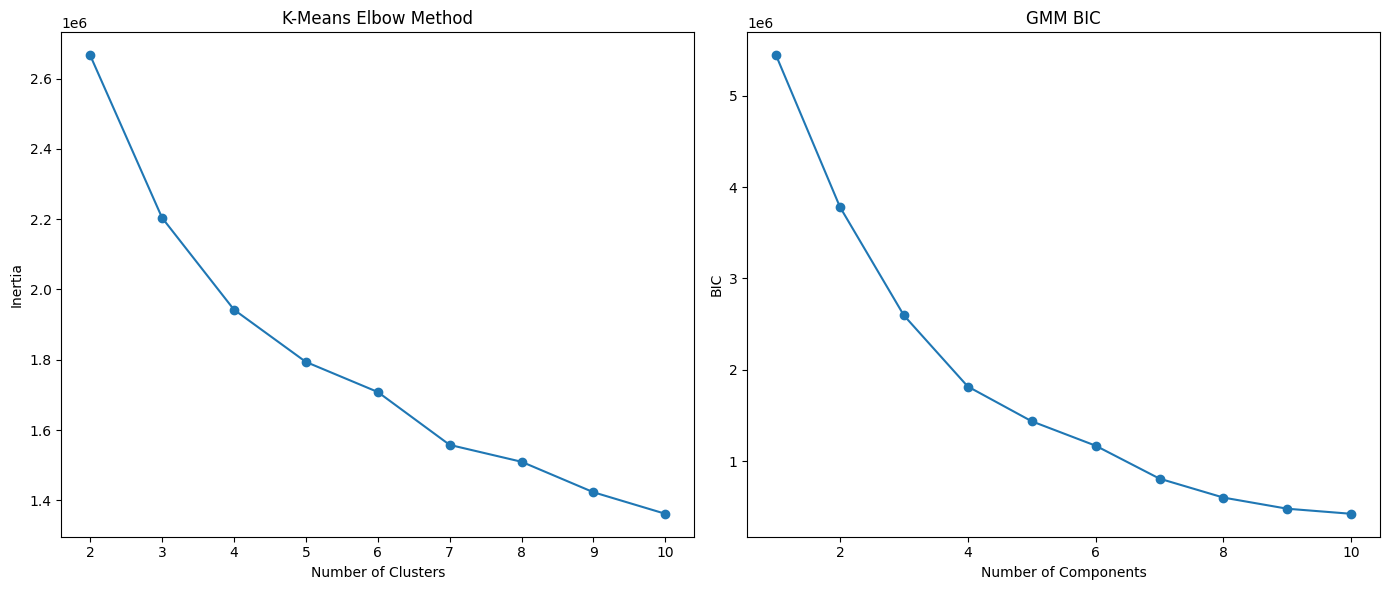

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA

# 데이터 전처리
X_train_reshaped = x_train_tensor_normalize.reshape(x_train_tensor_normalize.shape[0], -1)
pca = PCA(n_components=50)
X_train_PCA = pca.fit_transform(X_train_reshaped)

# K-Means: 엘보우 메소드
inertia = []
silhouette_scores_kmeans = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_train_PCA)
    inertia.append(kmeans.inertia_)
    
    if len(set(clusters)) > 1:
        score = silhouette_score(X_train_PCA, clusters)
    else:
        score = -1
    silhouette_scores_kmeans.append(score)

# GMM: BIC 기반 최적 클러스터 수 결정
n_components_range = range(1, 11)
bics = []
silhouette_scores_gmm = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train_PCA)
    bics.append(gmm.bic(X_train_PCA))
    clusters = gmm.predict(X_train_PCA)
    
    if len(set(clusters)) > 1:
        score = silhouette_score(X_train_PCA, clusters)
    else:
        score = -1
    silhouette_scores_gmm.append(score)

# Agglomerative Clustering: 덴드로그램 사용, 최적 클러스터 수 직접 선택
agglo = AgglomerativeClustering(n_clusters=3,connectivity=connectivity)
agglo_clusters = agglo.fit_predict(X_train_PCA)
silhouette_score_agglo = silhouette_score(X_train_PCA, agglo_clusters)

# DBSCAN: eps와 min_samples 조정, 실루엣 점수 측정
eps_values = np.arange(0.1, 2.1, 0.1)
min_samples_values = range(2, 11)
best_silhouette_dbscan = -1
best_eps = None
best_min_samples = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_train_PCA)
        
        if len(set(clusters)) > 1:
            score = silhouette_score(X_train_PCA, clusters)
            if score > best_silhouette_dbscan:
                best_silhouette_dbscan = score
                best_eps = eps
                best_min_samples = min_samples

# 결과 출력
print(f'K-Means Silhouette Scores: {silhouette_scores_kmeans}')
print(f'Optimal K-Means Cluster: {cluster_range[np.argmax(silhouette_scores_kmeans)]}')
print(f'GMM BIC: {bics}')
print(f'Optimal GMM Cluster: {n_components_range[np.argmin(bics)]}, Silhouette Score: {silhouette_scores_gmm[np.argmin(bics)]}')
print(f'Agglomerative Clustering Silhouette Score: {silhouette_score_agglo}')
print(f'Best DBSCAN Parameters: eps={best_eps}, min_samples={best_min_samples}, Silhouette Score: {best_silhouette_dbscan}')

# 시각화
plt.figure(figsize=(14, 6))

# K-Means 엘보우 메소드 시각화
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia, marker='o')
plt.title('K-Means Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# GMM BIC 시각화
plt.subplot(1, 2, 2)
plt.plot(n_components_range, bics, marker='o')
plt.title('GMM BIC')
plt.xlabel('Number of Components')
plt.ylabel('BIC')

plt.tight_layout()
plt.show()


### 실루엣 점수를 통해 군집화 모델의 성능에 대한 간단한 해석을 적으세요.

0.5 이상: 클러스터링이 잘 이루어졌으며, 각 포인트가 적절한 클러스터에 속해 있음을 나타냄\
0.25 ~ 0.5: 클러스터링이 어느 정도 적절하지만 개선이 필요할 수 있음\
0 ~ 0.25: 클러스터가 명확하지 않으며, 클러스터링 품질이 낮음\
음수: 클러스터링이 잘못되었으며, 데이터 포인트가 잘못된 클러스터에 속해 있을 가능성이 높음

결론 \
K-Means Clustering이 최적의 클러스터 수가 2일 때 가장 높은 Silhouette Score를 가지므로 상대적으로 가장 우수한 방법\
Agglomerative 도 나쁘지 않음\
GMM은 BIC 기준으로는 좋은 결과를 보였으나 Silhouette Score가 낮아 실제 클러스터링 품질은 낮음\
DBSCAN은 주어진 데이터에 적합하지 않아 보임